In [1]:
import os
import pandas as pd
import numpy as np
from glob import glob
import nibabel as nib
from nilearn.plotting import plot_img, plot_stat_map, view_img, plot_prob_atlas
from nilearn.regions import connected_label_regions
from nilearn.glm.first_level.hemodynamic_models import spm_hrf
from nilearn.image import concat_imgs, mean_img, index_img
from nilearn.glm.first_level import FirstLevelModel
from nilearn.glm import threshold_stats_img
import matplotlib.pyplot as plt
from nilearn.plotting import plot_design_matrix
from nilearn.interfaces.fmriprep import load_confounds_strategy
from nilearn.plotting import plot_roi
from nilearn.maskers import NiftiMapsMasker, NiftiSpheresMasker, NiftiMasker
from nilearn import image
from nilearn.image import binarize_img
from nilearn.image import high_variance_confounds
import seaborn as sns
from nilearn.glm.first_level.design_matrix import make_first_level_design_matrix, check_design_matrix
from nilearn.masking import compute_multi_epi_mask

# Homemade functions

In [2]:
# Open a datasets directory. 
fd = os.open("/Users/luisalvarez/Documents/Datasets/IBC/sub-01/ses-03/func", os.O_RDONLY)

# Use os.fchdir() method to change the current dir/folder.
os.fchdir(fd)

# Safe check- Print current working directory
print("Current working dir : %s" % os.getcwd())

Current working dir : /Users/luisalvarez/Documents/Datasets/IBC/sub-01/ses-03/func


## Load and check Cartmell et al. (2019) NAc Probabilistic Atlas.


In [3]:
# Define path for each segment of the atlas. 
LH_core = "/Users/luisalvarez/Documents/Datasets/NAcc_ShellCore/lh-presumed-core.nii.gz"
RH_core = "/Users/luisalvarez/Documents/Datasets/NAcc_ShellCore/rh-presumed-core.nii.gz"
LH_shell = "/Users/luisalvarez/Documents/Datasets/NAcc_ShellCore/lh-presumed-shell.nii.gz"
RH_shell = "/Users/luisalvarez/Documents/Datasets/NAcc_ShellCore/rh-presumed-shell.nii.gz"

NAcc_files = [LH_core, RH_core, LH_shell, RH_shell]
NAcc_core_files = [LH_core, RH_core]
NAcc_shell_files = [LH_shell, RH_shell]

## Create normal masks for NAcc, core, and shell. 
# Merge files into single atlas. 
# Complete mask, both NAcc core and shell.
NAcc_imgs = image.load_img(NAcc_files, wildcards=True)
NAcc_atlas = image.math_img('np.sum(img, axis=-1, keepdims=True)', img=NAcc_imgs)
NAcc_atlas_masker = NiftiMapsMasker(
        maps_img=NAcc_atlas,
        allow_overlap=True)

# Core mask: only NAcc core.
NAcc_imgs_core = image.load_img(NAcc_core_files, wildcards=True)
NAcc_atlas_core = image.math_img('np.sum(img, axis=-1, keepdims=True)', img=NAcc_imgs_core)
NAcc_atlas_masker_core = NiftiMapsMasker(
        maps_img=NAcc_atlas_core,
        allow_overlap=True)

# Shell mask: only NAcc shell.
NAcc_imgs_shell = image.load_img(NAcc_shell_files, wildcards=True)
NAcc_atlas_shell = image.math_img('np.sum(img, axis=-1, keepdims=True)', img=NAcc_imgs_shell)
NAcc_atlas_masker_shell = NiftiMapsMasker(
        maps_img=NAcc_atlas_shell,
        allow_overlap=True)



In [4]:
# Create filtered masks for NAcc, core, and shell.
# For these masks, only voxels with higher than 35% probability of being part of NAcc will be considered.

NAcc_filt_matrix = NAcc_atlas.get_fdata().copy()
NAcc_filt_matrix[NAcc_filt_matrix < 0.35] = 0
NAcc_atlas_filtered = nib.Nifti1Image(NAcc_filt_matrix, NAcc_atlas.affine, NAcc_atlas.header)
NAcc_atlas_masker_filt = NiftiMapsMasker(
        maps_img=NAcc_atlas_filtered,
        allow_overlap=True)

NAcc_imgs_core_matrix = NAcc_imgs_core.get_fdata().copy()
NAcc_imgs_core_matrix[NAcc_imgs_core_matrix < 0.35] = 0
NAcc_imgs_core_filtered = nib.Nifti1Image(NAcc_imgs_core_matrix, NAcc_imgs_core.affine, NAcc_imgs_core.header)
NAcc_atlas_masker_core_filt = NiftiMapsMasker(
        maps_img=NAcc_imgs_core_filtered,
        allow_overlap=True)

NAcc_imgs_shell_matrix = NAcc_imgs_shell.get_fdata().copy()
NAcc_imgs_shell_matrix[NAcc_imgs_shell_matrix < 0.35] = 0
NAcc_imgs_shell_filtered = nib.Nifti1Image(NAcc_imgs_shell_matrix, NAcc_imgs_shell.affine, NAcc_imgs_shell.header)
NAcc_atlas_masker_shell_filt = NiftiMapsMasker(
        maps_img=NAcc_imgs_shell_filtered,
        allow_overlap=True)

In [57]:
# Create binary masks for NAcc, core, and shell.
NAcc_bin_matrix = NAcc_atlas.get_fdata().copy()
NAcc_bin_matrix[NAcc_bin_matrix > 0] = 1 # This one needs to be set to 1, not 0 because it's used for masking the ROI-GLM.
NAcc_atlas_bin = nib.Nifti1Image(NAcc_bin_matrix, NAcc_atlas.affine, NAcc_atlas.header)
NAcc_atlas_masker_bin = NiftiMasker(
        maps_img=NAcc_atlas_bin,
        allow_overlap=True)

NAcc_imgs_core_bin_matrix = NAcc_imgs_core.get_fdata().copy()
NAcc_imgs_core_bin_matrix[NAcc_imgs_core_bin_matrix > 0.3] = 1
NAcc_imgs_core_bin_matrix[NAcc_imgs_core_bin_matrix < 0.3] = 0
print("NAcc core img contains {} voxels".format(np.count_nonzero(NAcc_imgs_core_bin_matrix)))
NAcc_imgs_core_bin = nib.Nifti1Image(NAcc_imgs_core_bin_matrix, NAcc_imgs_core.affine, NAcc_imgs_core.header)
NAcc_atlas_masker_core_bin = NiftiMasker(
        maps_img=NAcc_imgs_core_bin,
        allow_overlap=True)

NAcc_imgs_shell_bin_matrix = NAcc_imgs_shell.get_fdata().copy()
NAcc_imgs_shell_bin_matrix[NAcc_imgs_shell_bin_matrix > 0.3] = 1
NAcc_imgs_shell_bin_matrix[NAcc_imgs_shell_bin_matrix < 0.3] = 0
print("NAcc shell img contains {} voxels".format(np.count_nonzero(NAcc_imgs_shell_bin_matrix)))
NAcc_imgs_shell_bin = nib.Nifti1Image(NAcc_imgs_shell_bin_matrix, NAcc_imgs_shell.affine, NAcc_imgs_shell.header)
NAcc_atlas_masker_shell_bin = NiftiMasker(
        maps_img=NAcc_imgs_shell_bin,
        allow_overlap=True)

# Get mean image, we'll use it later for plotting. 
NAcc_imgs_core_bin_mean = mean_img(NAcc_imgs_core_bin)
NAcc_imgs_core_bin_mean = nib.Nifti1Image(NAcc_imgs_core_bin_mean.get_fdata(), NAcc_imgs_core_bin_mean.affine, NAcc_imgs_core_bin_mean.header)

NAcc_imgs_shell_bin_mean = mean_img(NAcc_imgs_shell_bin)
NAcc_imgs_shell_bin_mean = nib.Nifti1Image(NAcc_imgs_shell_bin_mean.get_fdata(), NAcc_imgs_shell_bin_mean.affine, NAcc_imgs_shell_bin_mean.header)

NAcc_imgs_core_bin_mean.to_filename("/Users/luisalvarez/Documents/Datasets/NAcc_ShellCore/NAcc_core_mean.nii.gz")
NAcc_imgs_shell_bin_mean.to_filename("/Users/luisalvarez/Documents/Datasets/NAcc_ShellCore/NAcc_shell_mean.nii.gz")

NAcc_core_contour = "/Users/luisalvarez/Documents/Datasets/NAcc_ShellCore/NAcc_core_mean.nii.gz"
NAcc_shell_contour = "/Users/luisalvarez/Documents/Datasets/NAcc_ShellCore/NAcc_shell_mean.nii.gz"

NAcc core img contains 688 voxels
NAcc shell img contains 1352 voxels


In [7]:
# np.unique(NAcc_imgs_core.get_fdata())

# NAcc_imgs_core_filtered = NAcc_imgs_core.get_fdata()
# NAcc_imgs_core_filtered[NAcc_imgs_core_filtered < 0.2] = 0
# NAcc_imgs_core_filtered = nib.Nifti1Image(NAcc_imgs_core_filtered, NAcc_imgs_core.affine, NAcc_imgs_core.header)

# np.unique(NAcc_imgs_core_filtered.get_fdata())

In [8]:
# NAcc_core_right_atlas_masker = NiftiMapsMasker(
#         maps_img=NAcc_atlas,
#         allow_overlap=True)

In [9]:
# NAcc_atlas_binary = binarize_img(NAcc_atlas)

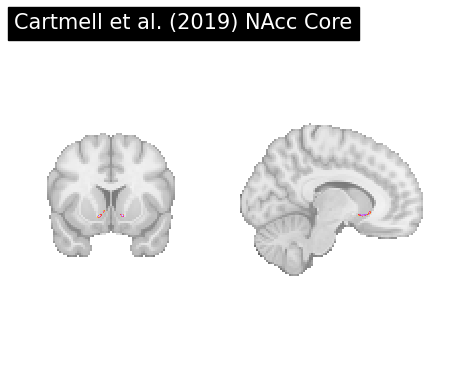

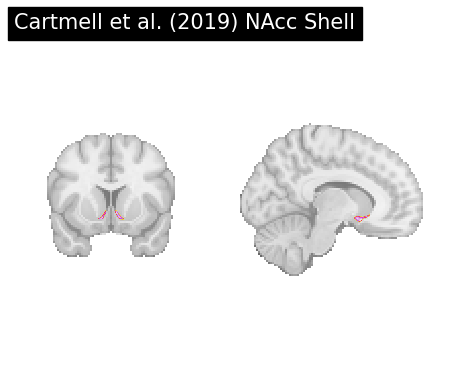

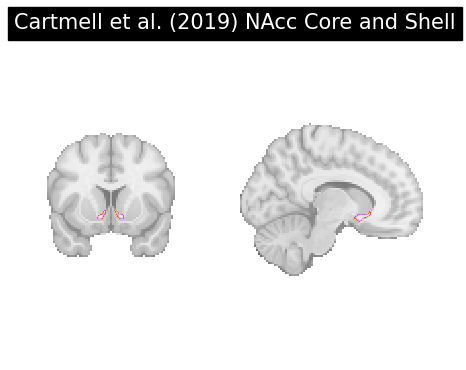

In [10]:
# Plot the atlases.
plot_roi(NAcc_atlas_core, display_mode="yx", cut_coords=(10, 12), title="Cartmell et al. (2019) NAcc Core", annotate=False, draw_cross=False)
plot_roi(NAcc_atlas_shell, display_mode="yx", cut_coords=(10, 12), title="Cartmell et al. (2019) NAcc Shell", annotate=False, draw_cross=False)
plot_roi(NAcc_atlas, display_mode="yx", cut_coords=(10, 12), title="Cartmell et al. (2019) NAcc Core and Shell", annotate=False, draw_cross=False)


## Load fMRI files. 

In [11]:
# Load the functional files.
nii_files = glob(os.path.join(os.getcwd(), "*Gambling*.nii*"))
nii_files = sorted(nii_files)
print(nii_files)

# Load the confounds file.
confounds_files = glob(os.path.join(os.getcwd(), "*Gambling*confounds*"))
confounds_files = sorted(confounds_files)
print(confounds_files)

useful_cols = ['tx', 'ty', 'tz', 'rx', 'ry', 'rz']

confounds_files = [pd.read_csv(file, usecols=useful_cols, sep="\t") for file in confounds_files]

# Load the events file.
events_files = glob(os.path.join(os.getcwd(), "*Gambling*events*"))
events_files = sorted(events_files)
print(events_files)

# Load anatomical file.
anat_file = "/Users/luisalvarez/Documents/Datasets/IBC/sub-01/ses-0/anat/sub-01_ses-00_space-MNI152NLin2009cAsym_label-GM_probseg.nii.gz"


['/Users/luisalvarez/Documents/Datasets/IBC/sub-01/ses-03/func/sub-01_ses-03_task-HcpGambling_dir-ap_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz', '/Users/luisalvarez/Documents/Datasets/IBC/sub-01/ses-03/func/sub-01_ses-03_task-HcpGambling_dir-pa_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz']
['/Users/luisalvarez/Documents/Datasets/IBC/sub-01/ses-03/func/sub-01_ses-03_task-HcpGambling_dir-ap_desc-confounds_timeseries.tsv', '/Users/luisalvarez/Documents/Datasets/IBC/sub-01/ses-03/func/sub-01_ses-03_task-HcpGambling_dir-pa_desc-confounds_timeseries.tsv']
['/Users/luisalvarez/Documents/Datasets/IBC/sub-01/ses-03/func/sub-01_ses-03_task-HcpGambling_dir-ap_events.tsv', '/Users/luisalvarez/Documents/Datasets/IBC/sub-01/ses-03/func/sub-01_ses-03_task-HcpGambling_dir-pa_events.tsv']


In [12]:
# Create mask for each run.
mask_img = compute_multi_epi_mask(nii_files, upper_cutoff=.7, lower_cutoff=.4)

confounds_run1 = pd.DataFrame(high_variance_confounds(nii_files[0], percentile=5)) 

confounds_run1 = pd.concat([confounds_run1, confounds_files[0]], axis=1)

confounds_run2 = pd.DataFrame(high_variance_confounds(nii_files[1], mask_img=mask_img, percentile=5))

confounds_run2 = pd.concat([confounds_run2, confounds_files[1]], axis=1)

confounds_files = [confounds_run1, confounds_run2]


In [13]:
confounds_files[0]

,0,1,2,3,4,tx,ty,tz,rx,ry,rz
0,-0.029071,-0.097438,-0.051411,0.142916,-0.000564,1.421086e-14,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.079410,-0.055956,-0.068771,-0.053841,0.070702,-3.527298e-04,-0.009361,0.015562,0.000348,0.000042,0.000047
2,0.085940,0.060631,0.039980,0.119547,0.036281,-4.526497e-03,-0.001408,0.011296,0.000149,0.000023,0.000040
3,-0.027150,0.086009,0.039950,0.018605,-0.035123,-3.523057e-03,0.020809,-0.003080,0.000466,-0.000062,0.000030
4,-0.084757,-0.059539,0.013596,0.055803,0.027782,-5.850399e-03,0.013442,0.001887,0.000248,-0.000040,-0.000046
...,...,...,...,...,...,...,...,...,...,...,...
183,0.069206,0.063495,0.048438,0.061749,0.047995,-1.223419e-01,-0.021668,-0.138387,0.002663,-0.001911,-0.002191
184,-0.036728,-0.037083,0.017977,-0.057991,-0.035582,-9.553273e-02,-0.008547,-0.104818,0.003019,-0.001236,-0.002178
185,-0.061166,0.070021,0.041031,0.055324,0.112124,-8.120518e-02,-0.012865,0.035289,0.002215,-0.001269,-0.002199
186,0.031118,0.112714,0.150983,0.025578,0.011716,-9.623924e-02,-0.067303,-0.026390,0.003091,-0.001740,-0.001991


## Create GLM model.

In [14]:
NAcc_atlas_bin_resampled = image.resample_to_img(NAcc_atlas_bin, nii_files[0], interpolation="nearest")

In [15]:
# Create GLM object for ROI-based analysis.
NAcc_glm = FirstLevelModel(
    t_r=2,
    noise_model="ar1",
    standardize=False,
    hrf_model="spm + derivative", 
    high_pass= 1/128,
    slice_time_ref=0.5,
    mask_img=NAcc_atlas_bin_resampled,
    smoothing_fwhm=5)

# Create GLM object for whole-brain analysis.
whole_glm = FirstLevelModel(
    t_r=2,
    noise_model="ar1",
    standardize=False,
    hrf_model="spm + derivative", 
    high_pass= 1/128,
    slice_time_ref=0.5,
    mask_img=mask_img,
    smoothing_fwhm=5)

In [16]:
# Fit GLM model. Note it requires as input the fmri file, the events dataframe, and the confounds dataframe. 
NAcc_glm_gamble = NAcc_glm.fit(nii_files[0], events_files[0], confounds_files[0])

whole_glm_gamble = whole_glm.fit(nii_files[0], events_files[0], confounds_files[0])



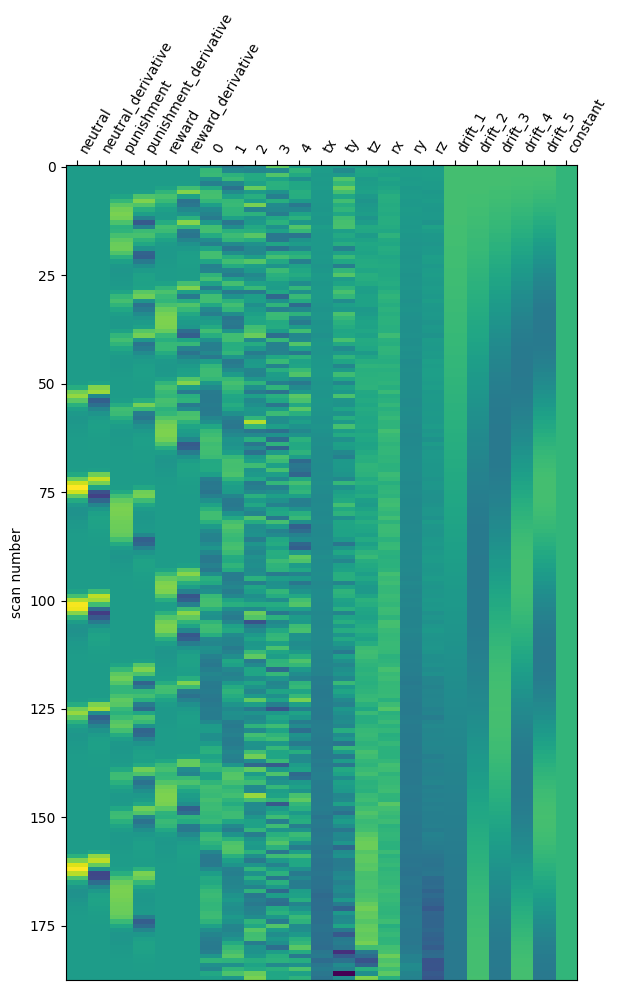

In [17]:
plot_design_matrix(NAcc_glm_gamble.design_matrices_[0])

plt.show()

In [18]:
# mask_test = nib.load(NAcc_atlas_masker_core_filt)
# mask_test.get_fdata().shape
NAcc_atlas_masker_core_filt

NAcc_imgs_core_bin_resampled = image.resample_to_img(NAcc_imgs_core_bin_mean, nii_files[0], interpolation="nearest")
NAcc_imgs_shell_bin_resampled = image.resample_to_img(NAcc_imgs_shell_bin_mean, nii_files[0], interpolation="nearest")



/Users/luisalvarez/opt/anaconda3/lib/python3.9/site-packages/nilearn/glm/thresholding.py:297: UserWarning: The given float value must not exceed 3.2071173383410807. But, you have given threshold=inf.
  stat_img = threshold_img(


Reward - Punishment FDR p<0.05 threshold: 2.797
Reward - Neutral FDR p<0.05 threshold: 3.402
Punishment - Neutral FDR p<0.05 threshold: inf


/Users/luisalvarez/opt/anaconda3/lib/python3.9/site-packages/nilearn/plotting/img_plotting.py:536: UserWarning: Non-finite values detected. These values will be replaced with zeros.
  data = safe_get_data(anat_img, ensure_finite=True)
/Users/luisalvarez/opt/anaconda3/lib/python3.9/site-packages/nilearn/plotting/displays/_axes.py:74: UserWarning: The following kwargs were not used by contour: 'contours', 'linewidth'
  im = getattr(ax, type)(


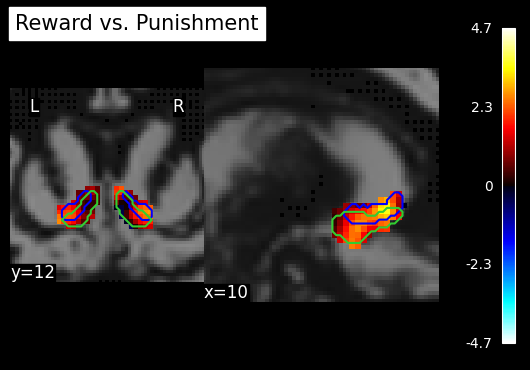

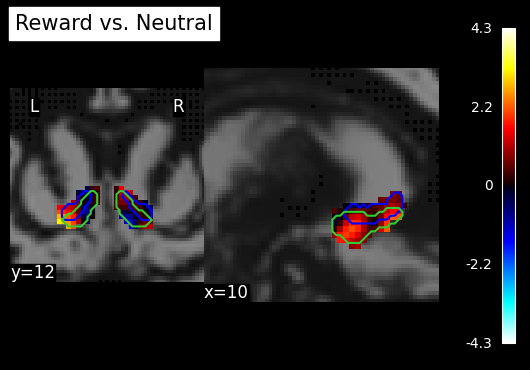

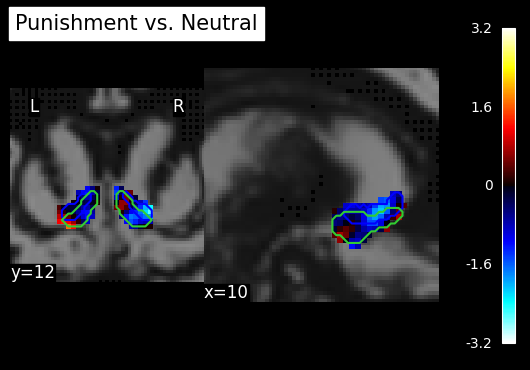

In [64]:
# Create the orthogonal contrast to the create image. Note, the sum of all elements equals zero.
reward_minus_punishment = "+1*reward-1*punishment"
reward_minus_neutral = "+1*reward-1*neutral"
punishment_minus_neutral = "+1*punishment-1*neutral"

reward_minus_punishment_z_map = NAcc_glm_gamble.compute_contrast(contrast_def=reward_minus_punishment, stat_type="t", output_type="z_score")
reward_minus_neutral_z_map = NAcc_glm_gamble.compute_contrast(contrast_def=reward_minus_neutral, stat_type="t", output_type="z_score")
punishment_minus_neutral_z_map = NAcc_glm_gamble.compute_contrast(contrast_def=punishment_minus_neutral, stat_type="t", output_type="z_score")

reward_minus_punishment_thresholded_map, reward_minus_punishment_threshold = threshold_stats_img(reward_minus_punishment_z_map, alpha=0.05, height_control="fdr", cluster_threshold=0)
reward_minus_neutral_thresholded_map, reward_minus_neutral_threshold = threshold_stats_img(reward_minus_neutral_z_map, alpha=0.05, height_control="fdr", cluster_threshold=0)
punishment_minus_neutral_thresholded_map, punishment_minus_neutral_threshold = threshold_stats_img(punishment_minus_neutral_z_map, alpha=0.05, height_control="fdr", cluster_threshold=0)

print(f"Reward - Punishment FDR p<0.05 threshold: {reward_minus_punishment_threshold:.3f}")
print(f"Reward - Neutral FDR p<0.05 threshold: {reward_minus_neutral_threshold:.3f}")
print(f"Punishment - Neutral FDR p<0.05 threshold: {punishment_minus_neutral_threshold:.3f}")

NAcc_rew_pun_fig = plot_stat_map(
    reward_minus_punishment_z_map,
    threshold=0,#2.797,
    display_mode="yx",
    cut_coords=(10, 12),
    bg_img=anat_file,
    draw_cross=False,
    title="Reward vs. Punishment"
)

NAcc_rew_pun_fig.axes['y'].ax.set_xlim(-30, 30)
NAcc_rew_pun_fig.axes['y'].ax.set_ylim(-30, 30)
NAcc_rew_pun_fig.axes['x'].ax.set_xlim(-30, 30)
NAcc_rew_pun_fig.axes['x'].ax.set_ylim(-30, 30)

NAcc_rew_neu_fig = plot_stat_map(
    reward_minus_neutral_z_map,
    threshold=0,#2.797,
    display_mode="yx",
    cut_coords=(10, 12),
    bg_img=anat_file,
    draw_cross=False,
    title="Reward vs. Neutral"
)

NAcc_rew_neu_fig.axes['y'].ax.set_xlim(-30, 30)
NAcc_rew_neu_fig.axes['y'].ax.set_ylim(-30, 30)
NAcc_rew_neu_fig.axes['x'].ax.set_xlim(-30, 30)
NAcc_rew_neu_fig.axes['x'].ax.set_ylim(-30, 30)

NAcc_pun_neu_fig = plot_stat_map( 
    punishment_minus_neutral_z_map,
    threshold=0,#2.797,
    display_mode="yx",
    cut_coords=(10, 12),
    bg_img=anat_file,
    draw_cross=False,
    title="Punishment vs. Neutral"
)

NAcc_pun_neu_fig.axes['y'].ax.set_xlim(-30, 30)
NAcc_pun_neu_fig.axes['y'].ax.set_ylim(-30, 30)
NAcc_pun_neu_fig.axes['x'].ax.set_xlim(-30, 30)
NAcc_pun_neu_fig.axes['x'].ax.set_ylim(-30, 30)

masks = [NAcc_core_contour, NAcc_shell_contour]
colors = ["blue", "limegreen"]

for mask, color in zip(masks, colors):
    NAcc_rew_pun_fig.add_contours(
        mask,
        contours=0.1,
        antialiased=True,
        linewidth=1,
        levels=[0],
        colors=[color])
    NAcc_rew_neu_fig.add_contours(
        mask,
        contours=0.1,
        antialiased=True,
        linewidth=1,
        levels=[0],
        colors=[color])
    NAcc_pun_neu_fig.add_contours(
        mask,
        contours=0.1,
        antialiased=True,
        linewidth=1,
        levels=[0],
        colors=[color])



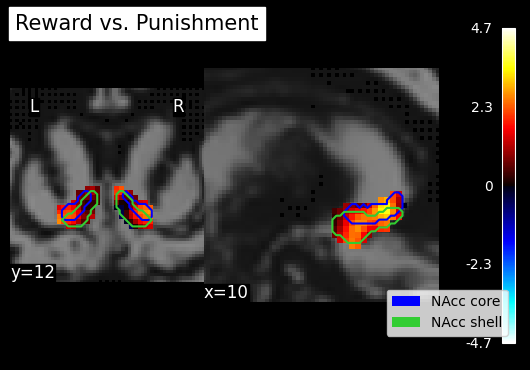

In [63]:
# Check how to add contours to the plots. 

masks = [NAcc_core_contour, NAcc_shell_contour]
colors = ["blue", "red"]
NAcc_rew_pun_fig = plot_stat_map(
    reward_minus_punishment_z_map,
    threshold=0,#2.797,
    display_mode="yx",
    cut_coords=(10, 12),
    bg_img=anat_file,
    draw_cross=False,
    title="Reward vs. Punishment"
)

NAcc_rew_pun_fig.axes['y'].ax.set_xlim(-30, 30)
NAcc_rew_pun_fig.axes['y'].ax.set_ylim(-30, 30)
NAcc_rew_pun_fig.axes['x'].ax.set_xlim(-30, 30)
NAcc_rew_pun_fig.axes['x'].ax.set_ylim(-30, 30)

masks = [NAcc_core_contour, NAcc_shell_contour]
colors = ["blue", "limegreen"]
for mask, color in zip(masks, colors):
    NAcc_rew_pun_fig.add_contours(
        mask,
        contours=0.1,
        antialiased=True,
        linewidth=1,
        levels=[0],
        colors=[color],
    )

from matplotlib.patches import Rectangle

core_r = Rectangle((0, 0), 1, 1, fc="blue")
shell_r = Rectangle((0, 0), 1, 1, fc="limegreen")
plt.legend([core_r, shell_r], ["NAcc core", "NAcc shell"], loc="lower right")



In [21]:
# Normal masks.
reward_minus_punishment_NAcc =  NAcc_atlas_masker.fit_transform(reward_minus_punishment_z_map)
reward_minus_punishment_NAcc_inv =  NAcc_atlas_masker.inverse_transform(reward_minus_punishment_NAcc)
print("For the complete NAcc we have ", np.count_nonzero(reward_minus_punishment_NAcc_inv.get_fdata()), " non-zero voxels.")

# reward_minus_punishment_NAcc_bin =  NAcc_atlas_bin_masker.fit_transform(reward_minus_punishment_z_map)
# reward_minus_punishment_NAcc_bin_inv =  NAcc_atlas_bin_masker.inverse_transform(reward_minus_punishment_NAcc_bin)
# print("For the complete NAcc binary we have ", np.count_nonzero(reward_minus_punishment_NAcc_bin_inv.get_fdata()), " non-zero voxels.")

reward_minus_punishment_NAcc_core =  NAcc_atlas_masker_core.fit_transform(reward_minus_punishment_z_map)
reward_minus_punishment_NAcc_core_inv =  NAcc_atlas_masker_core.inverse_transform(reward_minus_punishment_NAcc_core)
print("For the NAcc core we have ", np.count_nonzero(reward_minus_punishment_NAcc_core_inv.get_fdata()), " non-zero voxels.")

reward_minus_punishment_NAcc_shell =  NAcc_atlas_masker_shell.fit_transform(reward_minus_punishment_z_map)
reward_minus_punishment_NAcc_shell_inv =  NAcc_atlas_masker_shell.inverse_transform(reward_minus_punishment_NAcc_shell)
print("For the NAcc shell we have ", np.count_nonzero(reward_minus_punishment_NAcc_shell_inv.get_fdata()), " non-zero voxels.")

# Filtered masks -> 80% probability a given voxel is part of the NAcc.
reward_minus_punishment_NAcc_filt = NAcc_atlas_masker_filt.fit_transform(reward_minus_punishment_z_map)
reward_minus_punishment_NAcc_filt_inv =  NAcc_atlas_masker_filt.inverse_transform(reward_minus_punishment_NAcc_filt)
print("For the NAcc filtered we have ", np.count_nonzero(reward_minus_punishment_NAcc_filt_inv.get_fdata()), " non-zero voxels.")

reward_minus_punishment_NAcc_core_filt = NAcc_atlas_masker_core_filt.fit_transform(reward_minus_punishment_z_map)
reward_minus_punishment_NAcc_core_filt_inv =  NAcc_atlas_masker_core_filt.inverse_transform(reward_minus_punishment_NAcc_core_filt)
print("For the NAcc core filtered we have ", np.count_nonzero(reward_minus_punishment_NAcc_core_filt_inv.get_fdata()), " non-zero voxels.")

reward_minus_punishment_NAcc_shell_filt = NAcc_atlas_masker_shell_filt.fit_transform(reward_minus_punishment_z_map)
reward_minus_punishment_NAcc_shell_filt_inv =  NAcc_atlas_masker_shell_filt.inverse_transform(reward_minus_punishment_NAcc_shell_filt)
print("For the NAcc shell filtered we have ", np.count_nonzero(reward_minus_punishment_NAcc_shell_filt_inv.get_fdata()), " non-zero voxels.")



For the complete NAcc we have  3972  non-zero voxels.
For the NAcc core we have  2849  non-zero voxels.
For the NAcc shell we have  3406  non-zero voxels.
For the NAcc filtered we have  1822  non-zero voxels.
For the NAcc core filtered we have  564  non-zero voxels.
For the NAcc shell filtered we have  1214  non-zero voxels.


In [22]:
reward_minus_punishment_NAcc_inv_thresholded_map, threshold = threshold_stats_img(reward_minus_punishment_NAcc_shell_filt_inv, alpha=0.05, height_control="fdr", cluster_threshold=0)
print(f"FDR p<0.05 threshold: {threshold:.3f}")

FDR p<0.05 threshold: inf


/Users/luisalvarez/opt/anaconda3/lib/python3.9/site-packages/nilearn/glm/thresholding.py:297: UserWarning: The given float value must not exceed 2.1977075063337486. But, you have given threshold=inf.
  stat_img = threshold_img(


In [23]:


# plot_stat_map(
#     reward_minus_punishment_NAcc_inv,
#     threshold=0,
#     display_mode="yx",
#     cut_coords=(10, 12),
#     bg_img=anat_file,
#     #black_bg=True,
#     draw_cross=False,
#     title="NAcc: Reward vs. Punishment"
# )
# plt.show()

In [24]:
# plot_stat_map(
#     reward_minus_punishment_NAcc_bin_inv,
#     threshold=0,
#     display_mode="yx",
#     cut_coords=(10, 12),
#     bg_img=anat_file,
#     #black_bg=True,
#     draw_cross=False,
#     title="NAcc bin mask: Reward vs. Punishment"
# )

In [25]:
# plot_stat_map(
#     reward_minus_punishment_NAcc_core_inv,
#     #threshold=0.1,
#     display_mode="yx",
#     cut_coords=(10, 12),
#     bg_img=anat_file,
#     #black_bg=True,
#     draw_cross=False,
#     title="NAcc core: Reward vs. Punishment"
# )
# plt.show()

In [26]:
# plot_stat_map(
#     reward_minus_punishment_NAcc_core_filt_inv,
#     #threshold=0.1,
#     display_mode="yx",
#     cut_coords=(10, 12),
#     bg_img=anat_file,
#     #black_bg=True,
#     draw_cross=False,
#     title="NAcc core filt: Reward vs. Punishment"
# )
# plt.show()

In [27]:
# plot_stat_map(
#     reward_minus_punishment_NAcc_shell_inv,
#     #threshold=0.1,
#     display_mode="yx",
#     cut_coords=(10, 12),
#     bg_img=anat_file,
#     #black_bg=True,
#     draw_cross=False,
#     title="NAcc shell: Reward vs. Punishment"
# )
# plt.show()

In [28]:
# plot_stat_map(
#     reward_minus_punishment_NAcc_shell_filt_inv,
#     #threshold=0.1,
#     display_mode="yx",
#     cut_coords=(10, 12),
#     bg_img=anat_file,
#     #black_bg=True,
#     draw_cross=False,
#     title="NAcc shell filt: Reward vs. Punishment"
# )
# plt.show()

/Users/luisalvarez/opt/anaconda3/lib/python3.9/site-packages/nilearn/plotting/img_plotting.py:536: UserWarning: Non-finite values detected. These values will be replaced with zeros.
  data = safe_get_data(anat_img, ensure_finite=True)


(-30.0, 30.0)

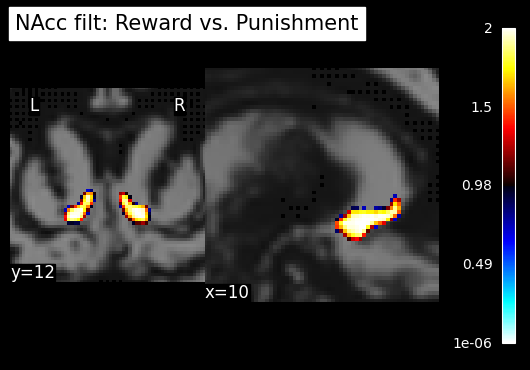

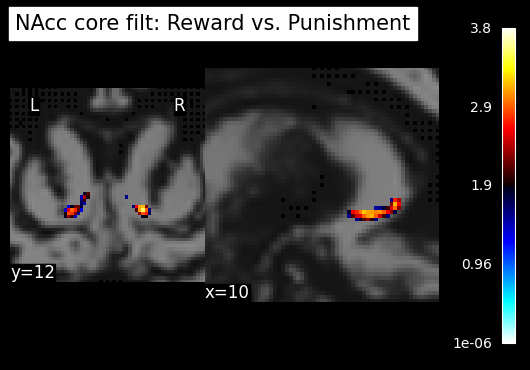

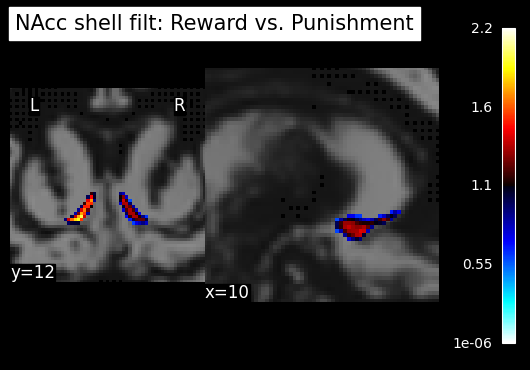

In [29]:
NAcc_fig = plot_stat_map(
    reward_minus_punishment_NAcc_filt_inv,
    display_mode="yx",
    cut_coords=(10, 12),
    bg_img=anat_file,
    draw_cross=False,
    title="NAcc filt: Reward vs. Punishment"
)

NAcc_fig.axes['y'].ax.set_xlim(-30, 30)
NAcc_fig.axes['y'].ax.set_ylim(-30, 30)
NAcc_fig.axes['x'].ax.set_xlim(-30, 30)
NAcc_fig.axes['x'].ax.set_ylim(-30, 30)

NAcc_core_fig = plot_stat_map(
    reward_minus_punishment_NAcc_core_filt_inv,
    display_mode="yx",
    cut_coords=(10, 12),
    bg_img=anat_file,
    draw_cross=False,
    title="NAcc core filt: Reward vs. Punishment")
 
NAcc_core_fig.axes['y'].ax.set_xlim(-30, 30)
NAcc_core_fig.axes['y'].ax.set_ylim(-30, 30)
NAcc_core_fig.axes['x'].ax.set_xlim(-30, 30)
NAcc_core_fig.axes['x'].ax.set_ylim(-30, 30)

NAcc_shell_fig = plot_stat_map(
    reward_minus_punishment_NAcc_shell_filt_inv,
    #threshold=0.1,
    display_mode="yx",
    cut_coords=(10, 12),
    bg_img=anat_file,
    #black_bg=True,
    draw_cross=False,
    title="NAcc shell filt: Reward vs. Punishment")

NAcc_shell_fig.axes['y'].ax.set_xlim(-30, 30)
NAcc_shell_fig.axes['y'].ax.set_ylim(-30, 30)
NAcc_shell_fig.axes['x'].ax.set_xlim(-30, 30)
NAcc_shell_fig.axes['x'].ax.set_ylim(-30, 30)



In [30]:
"""
#NAcc_atlas_data_matrix = NAcc_atlas.get_fdata().copy()
#NAcc_atlas_data_matrix[NAcc_atlas_data_matrix > 0] = 0 # This works the opposite way I would think. 
NAcc_atlas_data_matrix = binarize_img(NAcc_atlas, threshold=0.2)
NAcc_atlas_data_bin = nib.Nifti1Image(NAcc_atlas_data_matrix, NAcc_atlas.affine, NAcc_atlas.header)
NAcc_atlas_bin_masker = NiftiMasker(
        maps_img=NAcc_atlas_data_bin,
        allow_overlap=True)
"""

'\n#NAcc_atlas_data_matrix = NAcc_atlas.get_fdata().copy()\n#NAcc_atlas_data_matrix[NAcc_atlas_data_matrix > 0] = 0 # This works the opposite way I would think. \nNAcc_atlas_data_matrix = binarize_img(NAcc_atlas, threshold=0.2)\nNAcc_atlas_data_bin = nib.Nifti1Image(NAcc_atlas_data_matrix, NAcc_atlas.affine, NAcc_atlas.header)\nNAcc_atlas_bin_masker = NiftiMasker(\n        maps_img=NAcc_atlas_data_bin,\n        allow_overlap=True)\n'